In [1]:
from src.image.util import CustomizedDataset, train_model
from src.image.cnn import CNN

from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

import shutil

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

DATASET_PATH = Path('./augmented')

if DATASET_PATH.exists():
    shutil.rmtree(DATASET_PATH)

MODEL_DIR = Path("./models")
if MODEL_DIR.exists():
    shutil.rmtree(MODEL_DIR)
MODEL_DIR.mkdir(exist_ok=True)

In [3]:
!rm -rf merged
!rm -rf augmented
!mkdir merged
!cp -r train/* merged/
!cp -r dev/* merged/
!rm -f merged/*/*.wav

Create new dataset using image augmentation

In [4]:
!python3 src/image/augment.py --num_augmentations 75 --image_dir ./merged/ --output_dir ./augmented/

Augmenting classes: 31it [00:17,  1.78it/s]
Augmentation done.


In [5]:
dataset = CustomizedDataset(dataset_path=DATASET_PATH)

In [6]:
test, val = dataset.get_train_val()

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(test, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val, batch_size=32, shuffle=True, num_workers=2)

In [8]:
# Get the number of classes
num_classes = len(dataset.full_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 31


In [9]:
from typing import Dict, List

import matplotlib.pyplot as plt

def plot_training_history(history: Dict[str, List[float]], model_name: str):
    """
    Plots train/val loss, train/val accuracy, and learning rate over epochs,
    with a model name as the title.

    Args:
        history (dict): Dictionary with keys 'train_loss', 'val_loss', 'train_acc', 'val_acc', 'lr'
        model_name (str): Name of the model to display in the plot title.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Training History for {model_name}", fontsize=16)

    # Plot Loss
    axs[0, 0].plot(epochs, history["train_loss"], label="Train Loss")
    axs[0, 0].plot(epochs, history["val_loss"], label="Val Loss")
    axs[0, 0].set_title("Loss over Epochs")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot Accuracy
    axs[0, 1].plot(epochs, history["train_acc"], label="Train Acc")
    axs[0, 1].plot(epochs, history["val_acc"], label="Val Acc")
    axs[0, 1].set_title("Accuracy over Epochs")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Accuracy (%)")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot Learning Rate
    axs[1, 0].plot(epochs, history["lr"], label="Learning Rate", color="tab:green")
    axs[1, 0].set_title("Learning Rate over Epochs")
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("LR")
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Make the last subplot empty or add another metric if available
    axs[1, 1].axis('off')  # Turn off axes for the empty subplot

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Save plot as a file
    fig.savefig(MODEL_DIR / f"training_history_{model_name}.png")

In [10]:
MODELS = [
    CNN(num_classes=num_classes, out_channels=[8, 16, 32], fc_layers=[32], dropout_rate=0.4),
    CNN(num_classes=num_classes, out_channels=[8, 16, 32, 64], fc_layers=[64], dropout_rate=0.4),
    CNN(num_classes=num_classes, out_channels=[8, 16, 32, 64, 128], fc_layers=[128], dropout_rate=0.4),
    CNN(num_classes=num_classes, out_channels=[16, 32, 64], fc_layers=[64], dropout_rate=0.4),
]

print(MODELS[0].name)

CNN [8, 16, 32] + FC [32]


In [11]:
from torchsummary import summary

for model in MODELS:
    model = model.to(DEVICE)
    summary(model=model, input_size=(3, 80, 80), batch_size=32, device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 8, 80, 80]             224
       BatchNorm2d-2            [32, 8, 80, 80]              16
              ReLU-3            [32, 8, 80, 80]               0
         MaxPool2d-4            [32, 8, 40, 40]               0
            Conv2d-5           [32, 16, 40, 40]           1,168
       BatchNorm2d-6           [32, 16, 40, 40]              32
              ReLU-7           [32, 16, 40, 40]               0
         MaxPool2d-8           [32, 16, 20, 20]               0
            Conv2d-9           [32, 32, 20, 20]           4,640
      BatchNorm2d-10           [32, 32, 20, 20]              64
             ReLU-11           [32, 32, 20, 20]               0
        MaxPool2d-12           [32, 32, 10, 10]               0
           Linear-13                   [32, 32]         102,432
             ReLU-14                   

----- Training model: CNN [8, 16, 32] + FC [32] -----
Epoch [1/50] | Train Loss: 3.2209, Train Acc: 11.33% | Val Loss: 2.8564, Val Acc: 28.58% | LR: 0.000100
Epoch [2/50] | Train Loss: 2.7227, Train Acc: 22.79% | Val Loss: 2.2501, Val Acc: 46.64% | LR: 0.000100
Epoch [3/50] | Train Loss: 2.3136, Train Acc: 32.10% | Val Loss: 1.8297, Val Acc: 61.61% | LR: 0.000100
Epoch [4/50] | Train Loss: 2.0297, Train Acc: 39.64% | Val Loss: 1.5148, Val Acc: 71.48% | LR: 0.000100
Epoch [5/50] | Train Loss: 1.8126, Train Acc: 46.22% | Val Loss: 1.2758, Val Acc: 77.58% | LR: 0.000100
Epoch [6/50] | Train Loss: 1.6311, Train Acc: 50.62% | Val Loss: 1.1106, Val Acc: 82.38% | LR: 0.000100
Epoch [7/50] | Train Loss: 1.4900, Train Acc: 55.14% | Val Loss: 0.9549, Val Acc: 83.97% | LR: 0.000100
Epoch [8/50] | Train Loss: 1.3738, Train Acc: 58.59% | Val Loss: 0.8496, Val Acc: 87.08% | LR: 0.000100
Epoch [9/50] | Train Loss: 1.2527, Train Acc: 62.09% | Val Loss: 0.6984, Val Acc: 89.02% | LR: 0.000100
Epoch [10/

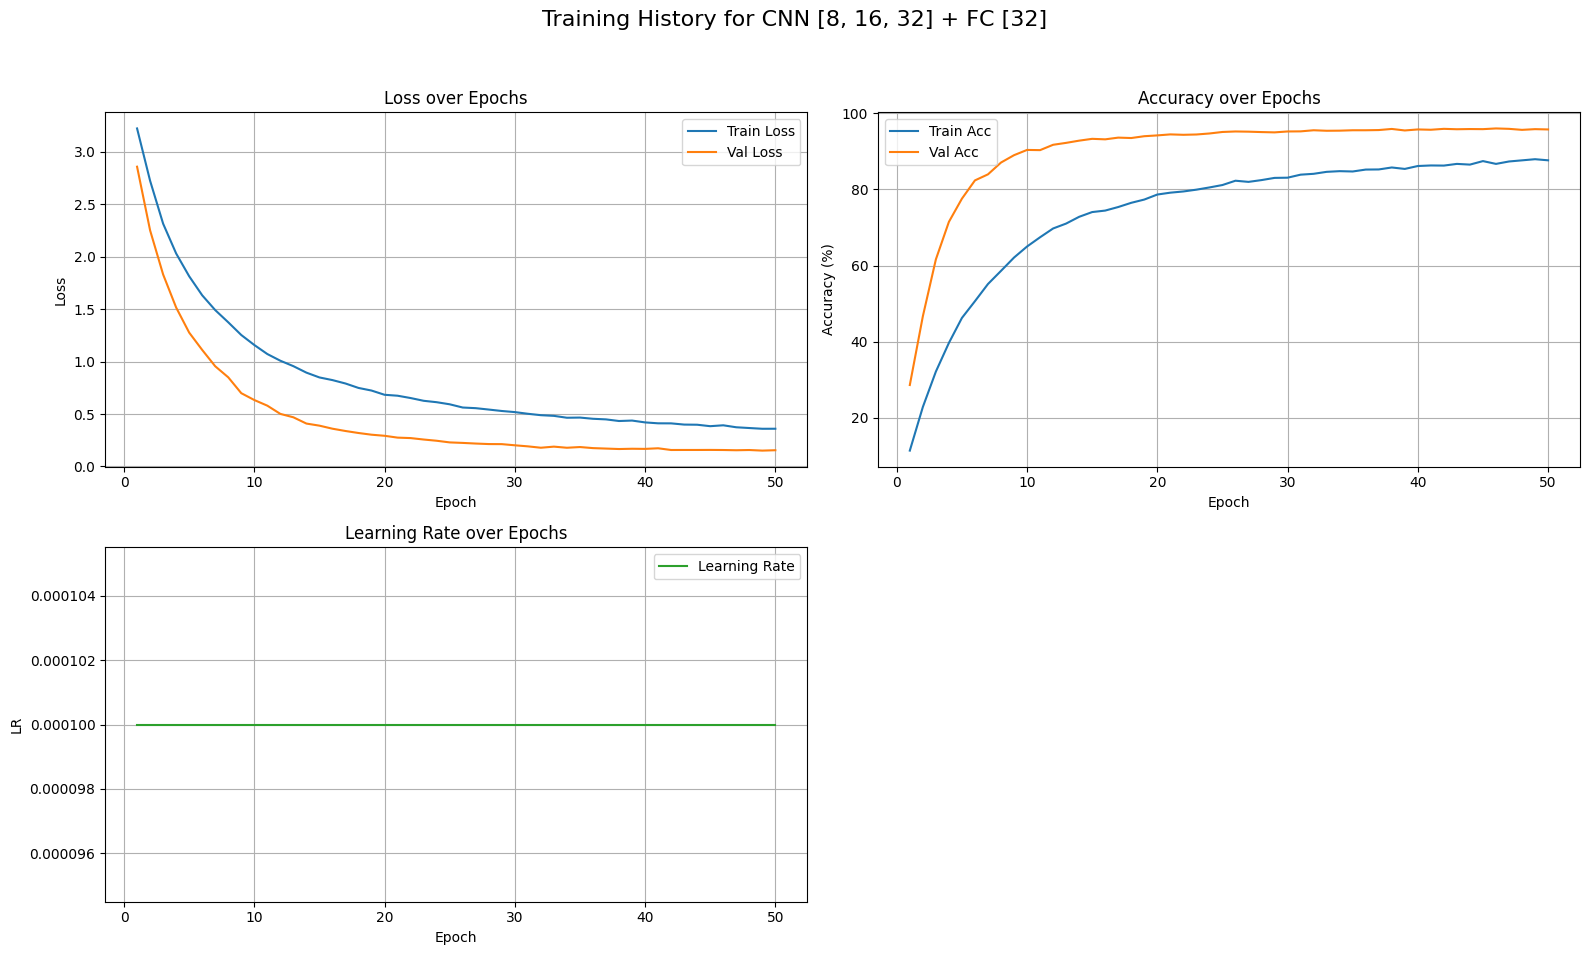

----- Training model: CNN [8, 16, 32, 64] + FC [64] -----
Epoch [1/50] | Train Loss: 3.1451, Train Acc: 13.18% | Val Loss: 2.6714, Val Acc: 32.08% | LR: 0.000100
Epoch [2/50] | Train Loss: 2.4506, Train Acc: 31.14% | Val Loss: 1.9498, Val Acc: 56.81% | LR: 0.000100
Epoch [3/50] | Train Loss: 1.9326, Train Acc: 44.95% | Val Loss: 1.4440, Val Acc: 72.19% | LR: 0.000100
Epoch [4/50] | Train Loss: 1.5343, Train Acc: 56.30% | Val Loss: 1.0670, Val Acc: 80.55% | LR: 0.000100
Epoch [5/50] | Train Loss: 1.2343, Train Acc: 65.83% | Val Loss: 0.7966, Val Acc: 87.18% | LR: 0.000100
Epoch [6/50] | Train Loss: 1.0131, Train Acc: 72.01% | Val Loss: 0.6129, Val Acc: 90.69% | LR: 0.000100
Epoch [7/50] | Train Loss: 0.8413, Train Acc: 77.31% | Val Loss: 0.4805, Val Acc: 92.54% | LR: 0.000100
Epoch [8/50] | Train Loss: 0.7162, Train Acc: 80.85% | Val Loss: 0.3827, Val Acc: 93.87% | LR: 0.000100
Epoch [9/50] | Train Loss: 0.6042, Train Acc: 83.75% | Val Loss: 0.3202, Val Acc: 94.67% | LR: 0.000100
Epoch 

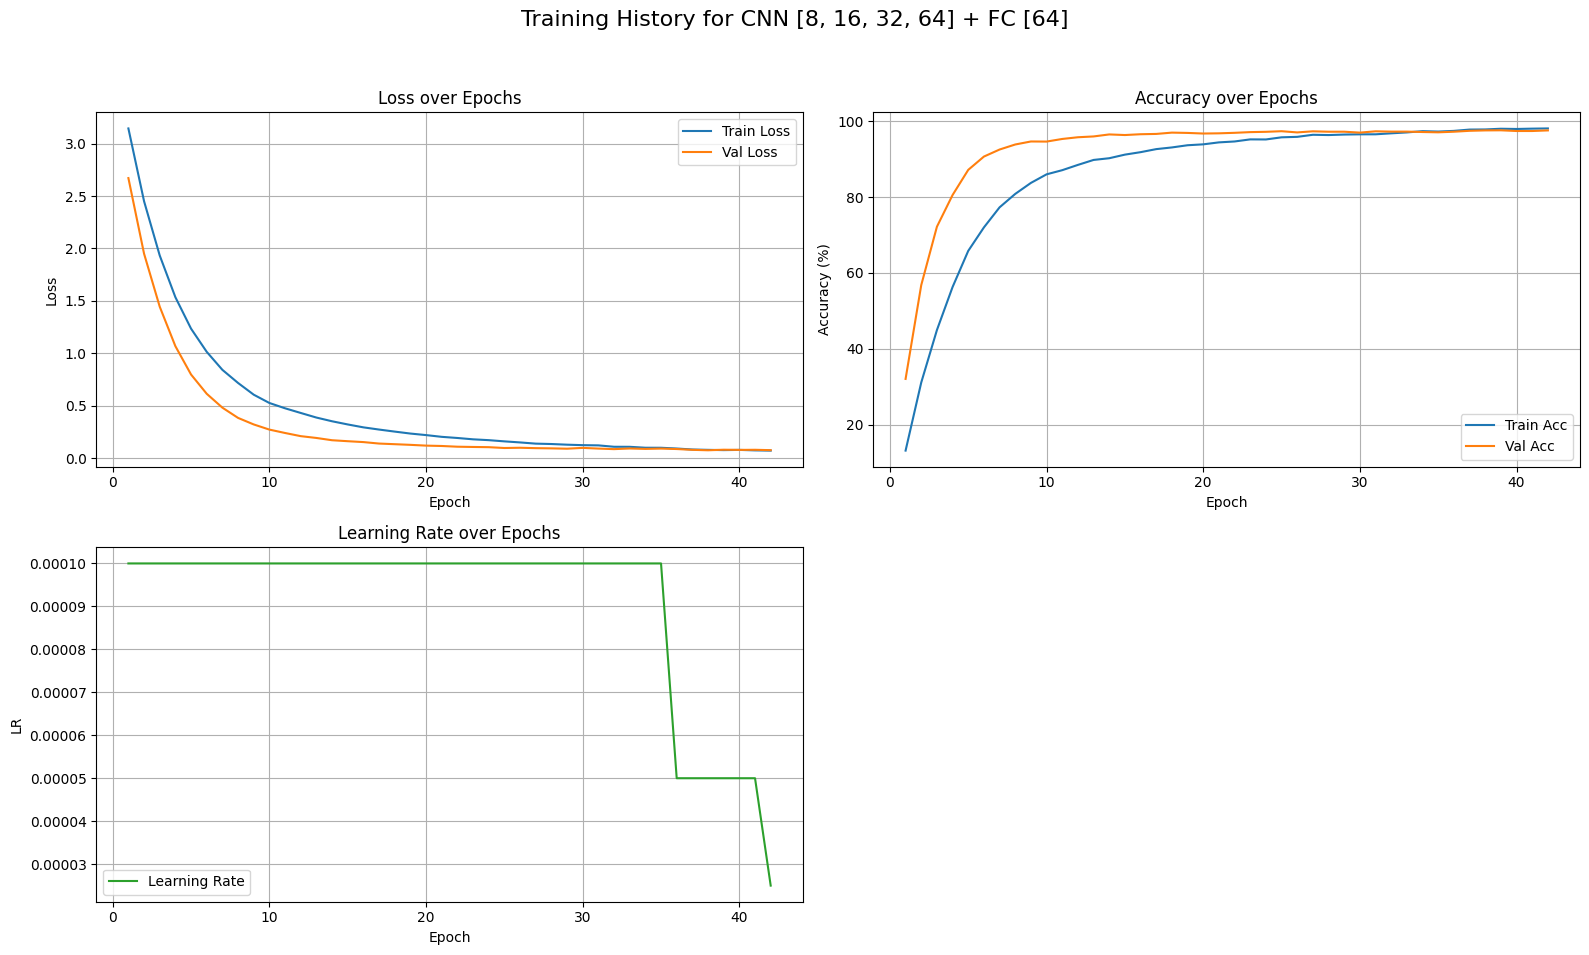

----- Training model: CNN [8, 16, 32, 64, 128] + FC [128] -----
Epoch [1/50] | Train Loss: 3.0160, Train Acc: 16.06% | Val Loss: 2.4116, Val Acc: 39.72% | LR: 0.000100
Epoch [2/50] | Train Loss: 2.1368, Train Acc: 40.67% | Val Loss: 1.5799, Val Acc: 66.54% | LR: 0.000100
Epoch [3/50] | Train Loss: 1.4445, Train Acc: 60.90% | Val Loss: 0.9762, Val Acc: 81.93% | LR: 0.000100
Epoch [4/50] | Train Loss: 0.9701, Train Acc: 75.36% | Val Loss: 0.6280, Val Acc: 89.44% | LR: 0.000100
Epoch [5/50] | Train Loss: 0.6869, Train Acc: 83.10% | Val Loss: 0.4474, Val Acc: 92.07% | LR: 0.000100
Epoch [6/50] | Train Loss: 0.4962, Train Acc: 88.12% | Val Loss: 0.3253, Val Acc: 93.95% | LR: 0.000100
Epoch [7/50] | Train Loss: 0.3807, Train Acc: 90.97% | Val Loss: 0.2539, Val Acc: 95.14% | LR: 0.000100
Epoch [8/50] | Train Loss: 0.2995, Train Acc: 92.80% | Val Loss: 0.2079, Val Acc: 95.99% | LR: 0.000100
Epoch [9/50] | Train Loss: 0.2426, Train Acc: 94.41% | Val Loss: 0.1818, Val Acc: 96.26% | LR: 0.000100


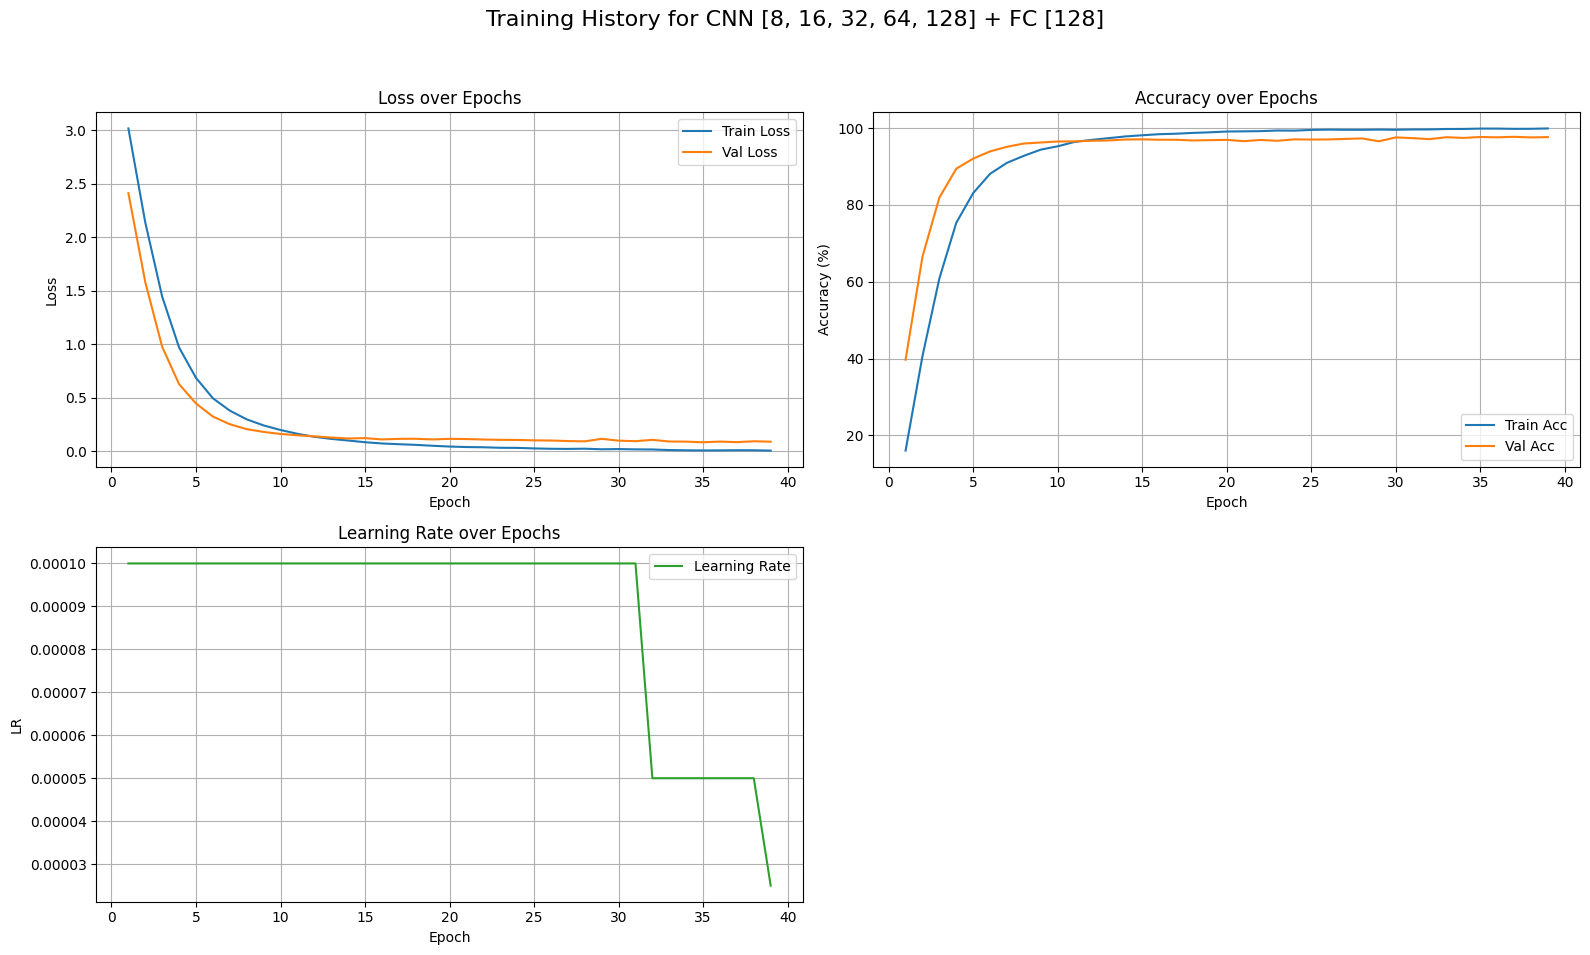

----- Training model: CNN [16, 32, 64] + FC [64] -----
Epoch [1/50] | Train Loss: 2.9974, Train Acc: 16.08% | Val Loss: 2.3104, Val Acc: 43.73% | LR: 0.000100
Epoch [2/50] | Train Loss: 2.1363, Train Acc: 39.35% | Val Loss: 1.4307, Val Acc: 72.72% | LR: 0.000100
Epoch [3/50] | Train Loss: 1.6014, Train Acc: 53.75% | Val Loss: 1.0132, Val Acc: 84.61% | LR: 0.000100
Epoch [4/50] | Train Loss: 1.2548, Train Acc: 64.20% | Val Loss: 0.7383, Val Acc: 89.84% | LR: 0.000100
Epoch [5/50] | Train Loss: 1.0522, Train Acc: 69.81% | Val Loss: 0.5563, Val Acc: 91.11% | LR: 0.000100
Epoch [6/50] | Train Loss: 0.8888, Train Acc: 73.94% | Val Loss: 0.4340, Val Acc: 92.84% | LR: 0.000100
Epoch [7/50] | Train Loss: 0.7752, Train Acc: 77.00% | Val Loss: 0.3581, Val Acc: 94.32% | LR: 0.000100
Epoch [8/50] | Train Loss: 0.6977, Train Acc: 79.36% | Val Loss: 0.3316, Val Acc: 94.61% | LR: 0.000100
Epoch [9/50] | Train Loss: 0.6402, Train Acc: 81.21% | Val Loss: 0.2696, Val Acc: 94.85% | LR: 0.000100
Epoch [10

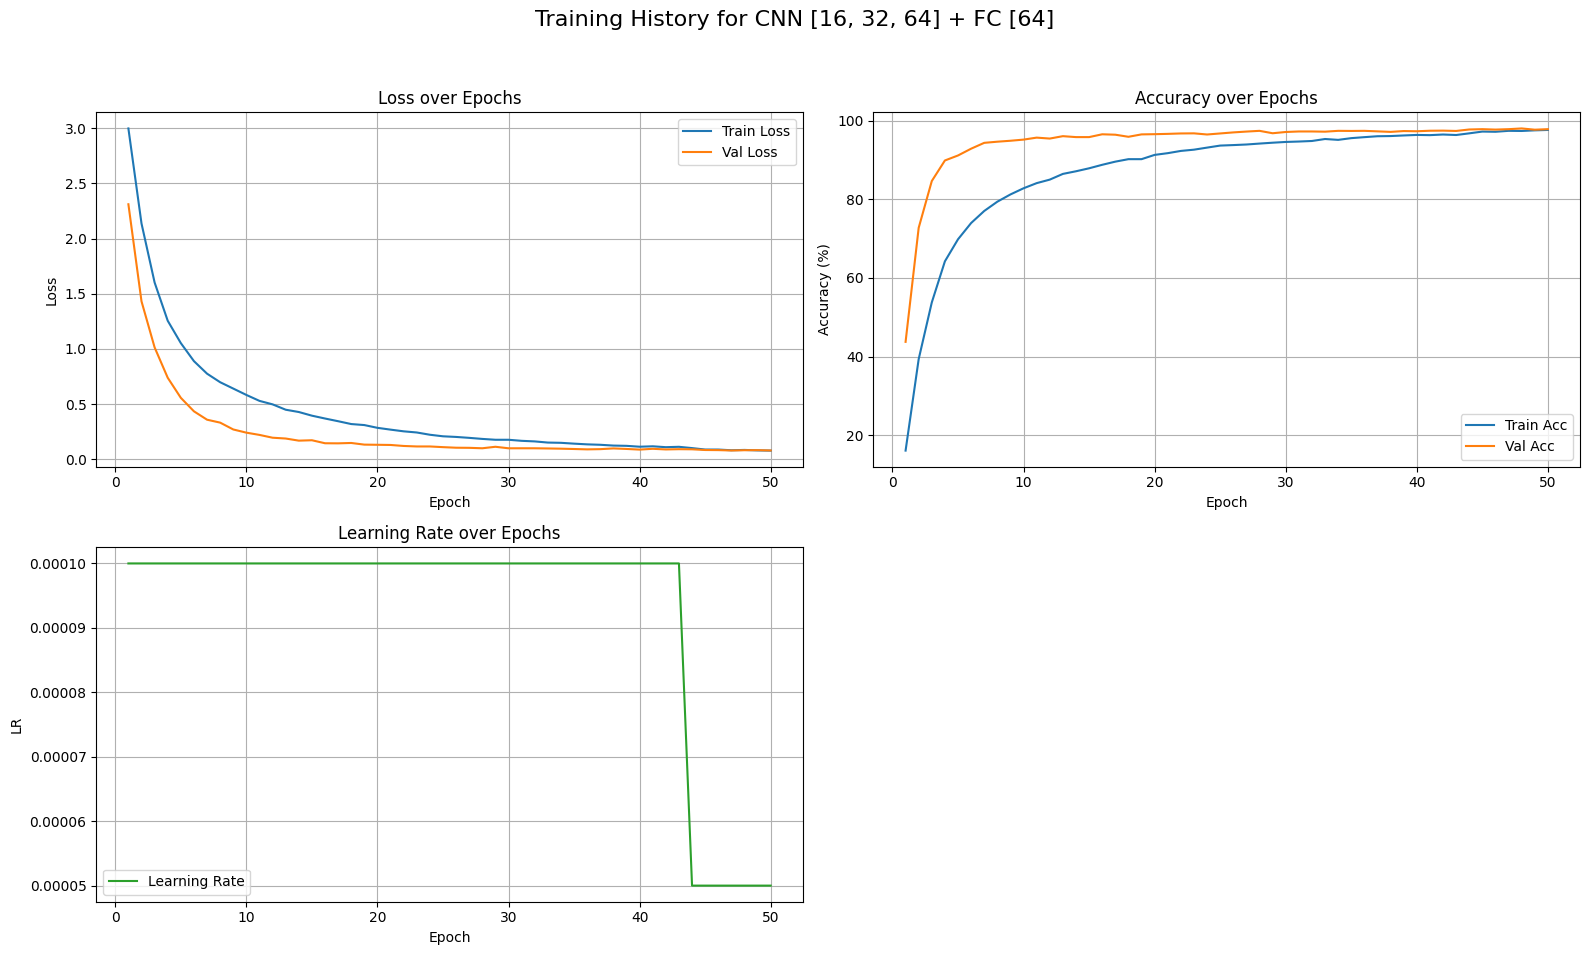

In [12]:
for model in MODELS:
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.00025, momentum=0.9, weight_decay=1e-4)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    print(f"----- Training model: {model.name} -----")

    history = train_model(model, train_loader, optimizer, criterion, epochs=50, scheduler=scheduler, validation_loader=val_loader, device=DEVICE, early_stopping_patience=5)
    plot_training_history(history, model_name=model.name)
    
    model_path = MODEL_DIR / f"{model.name}.pth"
    model.save(model_path)

In [14]:
model = MODELS[1]
model = CNN.load(str(MODEL_DIR / f"{model.name}.pth"))

In [16]:
!rm -rf ./eval-final/
!mkdir ./eval-final/
!cp -r ./eval/* ./eval-final/
!rm ./eval-final/*.wav

In [17]:
from PIL import Image
from torch.functional import F

def get_image_class_log_likelihood(model: CNN, image_path: str, device: torch.device) -> tuple[str, int, list[float]]:
    """Returns image name, predicted class, and log likelihoods."""
    model.eval()  # Set the model to evaluation mode
    model.to(device)

    try:
        image = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return -1  # Or raise an exception

    image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        logits = model(image_tensor)
        log_probabilities = F.log_softmax(logits, dim=1)
        predicted_class_index = log_probabilities.argmax(dim=1).item()
        predicted_class_name = dataset.idx_to_class[predicted_class_index]
        log_likelihood_list = log_probabilities.squeeze().tolist()

    return Path(image_path).name.removesuffix('.png'), predicted_class_name, log_likelihood_list

In [22]:
import os
from tqdm import tqdm

eval_image_dir = './eval-final/'
OUTPUT_TXT = Path('./image_cnn.txt')

if OUTPUT_TXT.exists():
    OUTPUT_TXT.unlink()

results = []

for image_path in tqdm(os.listdir(eval_image_dir)):
    image_path = eval_image_dir + image_path

    img_name, pred_class, log_likelihood_list = get_image_class_log_likelihood(model, image_path, DEVICE)

    with open(OUTPUT_TXT, 'a') as f:
        f.write(f"{img_name} {pred_class} {" ".join([str(i) for i in log_likelihood_list])}\n")

    results.append({
        'image_path': image_path,
        'predicted_class': pred_class,
    })

results

100%|██████████| 736/736 [00:01<00:00, 690.91it/s]


[{'image_path': './eval-final/eval_00628.png', 'predicted_class': '16'},
 {'image_path': './eval-final/eval_00526.png', 'predicted_class': '21'},
 {'image_path': './eval-final/eval_00325.png', 'predicted_class': '23'},
 {'image_path': './eval-final/eval_00349.png', 'predicted_class': '11'},
 {'image_path': './eval-final/eval_00309.png', 'predicted_class': '15'},
 {'image_path': './eval-final/eval_00611.png', 'predicted_class': '16'},
 {'image_path': './eval-final/eval_00545.png', 'predicted_class': '11'},
 {'image_path': './eval-final/eval_00698.png', 'predicted_class': '22'},
 {'image_path': './eval-final/eval_00537.png', 'predicted_class': '24'},
 {'image_path': './eval-final/eval_00133.png', 'predicted_class': '6'},
 {'image_path': './eval-final/eval_00123.png', 'predicted_class': '17'},
 {'image_path': './eval-final/eval_00406.png', 'predicted_class': '21'},
 {'image_path': './eval-final/eval_00595.png', 'predicted_class': '1'},
 {'image_path': './eval-final/eval_00101.png', 'predi

In [19]:
from pathlib import Path
import shutil

result_dir = Path('./results/')
if result_dir.exists():
    shutil.rmtree(result_dir)
result_dir.mkdir()

for item in results:
    image_path = Path(item['image_path'])
    class_dir = result_dir / item['predicted_class']
    class_dir.mkdir(exist_ok=True)

    # Copy the file to the class directory
    shutil.copy(image_path, class_dir)

In [20]:
# class: image_path
orig_class_img = {}

for image_dir in os.listdir("./test-images/"):
    image = os.listdir(f"./test-images/{image_dir}")[0] 
    orig_class_img[image_dir] = "./test-images/" + image_dir + "/" + image

orig_class_img

{'2': './test-images/2/f402_04_f12_i0_0.png',
 '28': './test-images/28/m429_04_p01_i0_0.png',
 '3': './test-images/3/f403_04_p01_i0_0.png',
 '27': './test-images/27/m428_04_p01_i0_0.png',
 '30': './test-images/30/m431_04_f12_i0_0.png',
 '6': './test-images/6/f406_04_f12_i0_0.png',
 '16': './test-images/16/m414_04_r06_i0_0.png',
 '9': './test-images/9/f409_04_p01_i0_0.png',
 '24': './test-images/24/m425_04_f12_i0_0.png',
 '17': './test-images/17/m417_04_f12_i0_0.png',
 '23': './test-images/23/m424_04_p01_i0_0.png',
 '22': './test-images/22/m423_04_p01_i0_0.png',
 '5': './test-images/5/f405_04_f12_i0_0.png',
 '7': './test-images/7/f407_04_f12_i0_0.png',
 '14': './test-images/14/f415_04_f12_i0_0.png',
 '12': './test-images/12/f412_04_p01_i0_0.png',
 '19': './test-images/19/m420_04_f12_i0_0.png',
 '10': './test-images/10/f410_04_f12_i0_0.png',
 '11': './test-images/11/f411_04_f12_i0_0.png',
 '21': './test-images/21/m422_04_r06_i0_0.png',
 '31': './test-images/31/m432_04_p01_i0_0.png',
 '15

In [ ]:
# from PIL import Image

# def create_comparison_image(original_path, predicted_path):
#     """Creates a side-by-side comparison image."""
#     original_image = Image.open(original_path).convert('RGB')
#     predicted_image = Image.open(predicted_path).convert('RGB')

#     # Ensure both images have the same height for side-by-side display
#     if original_image.height != predicted_image.height:
#         min_height = min(original_image.height, predicted_image.height)
#         original_image = original_image.resize((int(original_image.width * min_height / original_image.height), min_height))
#         predicted_image = predicted_image.resize((int(predicted_image.width * min_height / predicted_image.height), min_height))

#     new_width = original_image.width + predicted_image.width
#     new_height = original_image.height
#     comparison_image = Image.new('RGB', (new_width, new_height))
#     comparison_image.paste(original_image, (0, 0))
#     comparison_image.paste(predicted_image, (original_image.width, 0))
#     return comparison_image

# for result in results:
#     cls = str(result['predicted_class'])
#     predicted_image_path = result['image_path']

#     if cls in orig_class_img:
#         original_image_path = orig_class_img[cls]
#         comparison_img = create_comparison_image(original_image_path, predicted_image_path)
#         # Save the comparison image, you might want to adjust the naming
#         comparison_img.save(f"./comparison_images/comparison_{os.path.basename(predicted_image_path)}")
#     else:
#         print(f"Warning: Original image for class '{cls}' not found.")